# Introduction

In [1]:
import numpy as np
import pytomography
from pytomography.algorithms import OSEMBSR
from pytomography.metadata import PSFMeta
from pytomography.priors import RelativeDifferencePrior
from pytomography.callbacks import CallBack
from pytomography.io.SPECT import simind
from pytomography.transforms import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.projections import SPECTSystemMatrix
from pytomography.utils import rotate_detector_z
from torchmetrics.image import StructuralSimilarityIndexMeasure
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from matplotlib import colors
import torch
from scipy.ndimage import zoom
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pytomography.device = device

/tmp/ipykernel_1777/4012073155.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [2]:
GT = np.fromfile('/home/gpuvmadm/PyTomography/test_files/quantitative/body1_Lu177_T2.bin', dtype=np.float32)
GT = GT.reshape((751,512,512))
GT = np.transpose(GT, (2,1,0))
GT = np.pad(GT, ((0,0),(0,0),(8,8)))
GT = zoom(GT, (128/512, 128/512, 384/767), order=0, mode='nearest')
calib = 0.21089022221130554

1. Reconstruct using PyTomography

In [3]:
headerfile = '/home/gpuvmadm/PyTomography/test_files/quantitative/body1t2ew6_tot_w2.hdr'
object_meta, image_meta = simind.get_metadata(headerfile)
photopeak = simind.get_projections(headerfile)
CT = simind.get_atteuation_map('/home/gpuvmadm/PyTomography/test_files/quantitative/body1.hct')
att_transform = SPECTAttenuationTransform(CT)
psf_meta = simind.get_psfmeta_from_header(headerfile)
psf_transform = SPECTPSFTransform(psf_meta)
system_matrix = SPECTSystemMatrix(
            obj2obj_transforms = [att_transform,psf_transform],
            im2im_transforms = [],
            object_meta = object_meta,
            image_meta = image_meta,
            n_parallel=15)
reconstruction_algorithm = OSEMBSR(
            image = photopeak,
            system_matrix = system_matrix)
reconstructed_object = reconstruction_algorithm(n_iters=2, n_subsets=8)
reconstructed_object = reconstructed_object[0].cpu().numpy() * calib

/data/home/gpuvmadm/PyTomography/src/pytomography/io/io_utils.py:43: RuntimeWarning: overflow encountered in exp
  return c1*np.exp(-d1*np.sqrt(energy)) + c2*np.exp(-d2*np.sqrt(energy))


2. Open reconstructed STIR file (obtained using `OSMAPOSL recon.par` in `test_files` folder)

In [4]:
reconstructed_object_stir = np.fromfile('/home/gpuvmadm/PyTomography/test_files/quantitative/OSEM_16.v', dtype=np.float32)
reconstructed_object_stir = np.transpose(reconstructed_object_stir.reshape(384,128,128)[::-1,::-1,::-1], (2,1,0)) * calib

In [5]:
s = 64
l1 = 167
l2 = 250
l3 = 315
#delta = reconstructed_object - reconstructed_object_stir

In [6]:
def plot_differences(ax,l, uppery=None, lowery=None):
    #plt.plot(GT[:,64,l], color='k', lw=2)
    stir = reconstructed_object_stir[:,64,l]
    pytomo = reconstructed_object[:,64,l]
    diff = stir - pytomo
    ax.plot(np.arange(128)*0.3,stir, marker='', ls='-', lw=1.5, color='k', label='STIR')
    ax.plot(np.arange(128)*0.3,pytomo, marker='', ls='--', lw=2.5, color='lightblue', label='PyTomography')
    ax.plot(np.arange(128)*0.3,diff, marker='', ls='-', lw=2.5, color='r', label='Difference', zorder=-10000)
    #ax.plot(np.arange(128)*0.3,np.abs(reconstructed_object[:,s,l]-reconstructed_object_stir[:,s,l])*100, ls='dotted', color='dimgrey', label='Difference (x100)')
    #plt.plot(delta[:,64,l])
    ax.grid()
    if uppery: ax.set_ylim(top=uppery)
    if lowery: ax.set_ylim(bottom=lowery)
    
def plot_object(ob, ax, add_text=False, mode='color'):
    if mode=='color':
        tcol = 'white'
        cmap = 'nipy_spectral'
        vmax = 1
    elif mode=='bw':
        tcol = 'red'
        cmap = 'Greys'
        vmax = 0.1
    im = ax.pcolormesh(ob[:,64].T, cmap=cmap, vmax=vmax)
    ax.axhline(l1, ls='--', color=tcol, lw=0.8)
    ax.axhline(l2, ls='--', color=tcol, lw=0.8)
    ax.axhline(l3, ls='--', color=tcol, lw=0.8)
    #ax.axis('off')
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if add_text:
        ax.text(5, l3+7, '1', ha='center', va='center', color=tcol, size=13)
        ax.text(5, l2+7, '2', ha='center', va='center', color=tcol, size=13)
        ax.text(5, l1+7, '3', ha='center', va='center', color=tcol, size=13)
    return im

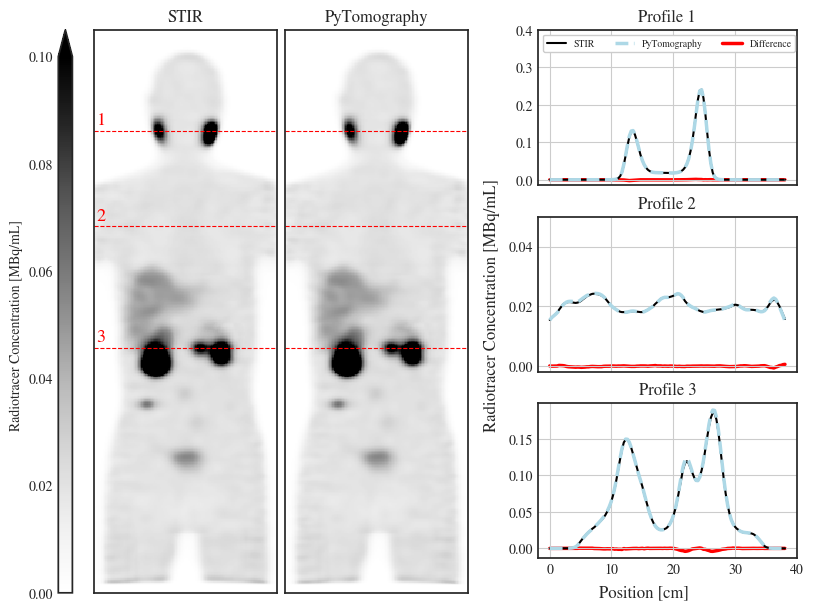

In [7]:
mode = 'bw'
fig = plt.figure(constrained_layout=True, figsize=(8,6))
(subfig_l, subfig_r) = fig.subfigures(nrows=1, ncols=2, width_ratios=(0.85,0.6))
axes_l = subfig_l.subplots(nrows=1, ncols=2)
axes_l[0].set_title('STIR')
axes_l[1].set_title('PyTomography')
im = plot_object(reconstructed_object_stir, axes_l[0], add_text=True, mode=mode)
im = plot_object(reconstructed_object, axes_l[1], mode=mode)
subfig_l.colorbar(im, ax=axes_l, location='left', label='Radiotracer Concentration [MBq/mL]', extend='max', aspect=40)
axes_r = subfig_r.subplots(nrows=3, ncols=1, sharex=True)
plot_differences(axes_r[0],l3)
axes_r[0].set_title('Profile 1')
axes_r[0].set_ylim(top=0.4)
axes_r[0].legend(loc='upper left', facecolor='white', framealpha=1, frameon=True, fontsize=7, ncol=3)
plot_differences(axes_r[1],l2, uppery=0.05, lowery=-0.002)
axes_r[1].set_title('Profile 2')
plot_differences(axes_r[2],l1)
axes_r[2].set_title('Profile 3')
subfig_r.supxlabel('Position [cm]')
subfig_r.supylabel('Radiotracer Concentration [MBq/mL]')
plt.savefig('py_vs_stir.png', dpi=300)

In [8]:
mask = reconstructed_object>0.05

In [9]:
np.max((reconstructed_object[mask] - reconstructed_object_stir[mask]) / reconstructed_object_stir[mask] * 100)

4.7675953

In [18]:
np.sqrt(((reconstructed_object - reconstructed_object_stir) ** 2).mean())

0.0003473538

In [12]:
r1 = torch.tensor(reconstructed_object).unsqueeze(0).unsqueeze(0)
r2 = torch.tensor(reconstructed_object_stir).unsqueeze(0).unsqueeze(0)

In [13]:
ssim = StructuralSimilarityIndexMeasure()

In [17]:
ssim(r1,r2).item()

0.9999635815620422